### **aperiodic_irasa**

Separate aperiodic activity from 1-60 Hz power spectra using the IRASA method, and compute the aperiodic slope and offset. 

IRASA described in: Wen, H, Liu, Z. Separating fractal and oscillatory components in the power spectrum of neurophysiological signal. *Brain Topography* 29 (2016). [https://doi.org/10.1007/s10548-015-0448-0](https://doi.org/10.1007/s10548-015-0448-0) 

Author: EL Johnson, PhD

Copyright (c) 2022-2025  
ZR Cross, PhD & EL Johnson, PhD

### Download the sample data file:
[https://drive.google.com/file/d/1KBlYuFC8-K31LRf22ueaTliSrNZENwnZ/view?usp=sharing](https://drive.google.com/file/d/1KBlYuFC8-K31LRf22ueaTliSrNZENwnZ/view?usp=sharing)

### Set directories:

In [72]:
datdir = 'C:\\Users\\elizl\\Downloads\\' # replace with your path to the downloaded data
savdir = datdir # replace with your save path

### Import modules:

In [73]:
import os
import numpy as np
import pandas as pd

!pip install mne
import mne

!pip install yasa
import yasa

### Read sample data file:

In [75]:
fid = 'NM01_new.mat-epo.fif.gz'
fid_pth = os.path.join(datdir, fid)
epochs = mne.read_epochs(fid_pth, preload = True)

Reading C:\Users\elizl\Downloads\NM01_new.mat-epo.fif.gz ...
Isotrak not found
    Found the data of interest:
        t =   -1000.00 ...    7500.00 ms
        0 CTF compensation matrices available
Not setting metadata
105 matching events found
No baseline correction applied
0 projection items activated


### Set subject ID and task:

In [76]:
sid = fid.split('_')[0] # extract subject ID from sample file ID
task = 'WM' # WM/Scene/Rest - the sample dataset is WM
print(f'Ready to process subject {sid}.')

Ready to process subject NM01.


### Extract info from the epoched data:

In [77]:
data = epochs.get_data(tmin = 0, tmax = 3) # 0 to 3 s from stimulus onset
sf = epochs.info['sfreq'] # sampling rate
chan = epochs.ch_names # channel names

### Run IRASA:

In [78]:
# initialize data frames
dfs = []
psd_total = []
df_aperiodic = []

# loop through trials
for idx in range(data.shape[0]):
    freqs, psd_aperiodic, psd_osc, fit_params = yasa.irasa(data[idx, :, :], sf, 
                                                               ch_names = chan, 
                                                               band = (1, 60), 
                                                               win_sec = 1, 
                                                               return_fit = True)
    
    # generate data frame for fit parameters
    fit_params.insert(loc = 0, column = 'epoch', value = idx) # add epoch column
    fit_params['subj'] = sid # add subject column
    fit_params['task'] = task # add task column
    dfs.append(fit_params) # append each epoch data frame
    
    # append the PSD arrays
    psd_total.append(psd_osc)
    
    # generate data frame for aperiodic component
    df_aperiodic_epoch = pd.DataFrame(psd_aperiodic)
    df_aperiodic_epoch.insert(loc = 0, column = 'epoch', value = idx)
    df_aperiodic_epoch['subj'] = sid # add subject column
    df_aperiodic_epoch['task'] = task # add task column
    df_aperiodic.append(df_aperiodic_epoch) # append each epoch data frame

### Save fit parameters:

In [79]:
df = pd.concat(dfs)
df.to_csv(f'{savdir}fit_params_trial_{sid}_{task}.csv', sep = ',', mode = 'a', header = True)
df.head() # show top of the saved table

,epoch,Chan,Intercept,Slope,R^2,std(osc),subj,task
0,0,csc008-csc007,14.979171,-1.516697,0.917546,70220.550440,NM01,WM
1,0,csc007-csc006,14.674741,-1.325805,0.867840,72542.865524,NM01,WM
2,0,csc006-csc005,16.341099,-1.594730,0.923872,447296.668174,NM01,WM
3,0,csc005-csc004,16.527774,-1.722348,0.964128,492393.587605,NM01,WM
4,0,csc004-csc003,16.129433,-1.653187,0.950075,216232.064604,NM01,WM


### Save aperiodic components:

In [80]:
df_aperiodic_df = pd.concat(df_aperiodic)
df_aperiodic_df.to_csv(f'{savdir}aperiodic_psd_trial_{sid}_{task}.csv', sep = ',', mode = 'a', header = True)
df_aperiodic_df.head() # show top of the saved table

,epoch,0,1,2,3,4,5,6,7,8,...,52,53,54,55,56,57,58,59,subj,task
0,0,9.744009e+05,4.098259e+05,3.051645e+05,2.914384e+05,235231.075198,222753.251553,238750.554964,227903.800107,202369.060384,...,5193.172395,5149.909223,5091.108816,4641.441804,3673.160303,3826.554113,3481.047740,3783.422578,NM01,WM
1,0,8.664586e+05,4.866235e+05,4.473815e+05,2.838001e+05,274049.711772,198837.191646,148494.153897,144975.776390,107548.596443,...,7749.557162,7365.043786,4341.709325,6029.652059,5304.342222,5468.248375,4563.048600,4775.348158,NM01,WM
2,0,3.176226e+06,1.849144e+06,1.891780e+06,1.279012e+06,770564.999383,586059.983001,530531.691125,600281.302602,430774.011578,...,12137.166525,12222.026024,13397.909166,14442.398837,11708.302667,10917.854668,9307.695033,10423.938161,NM01,WM
3,0,4.741931e+06,4.462196e+06,2.147539e+06,1.082982e+06,816401.460088,664964.191154,493043.809771,401171.762703,451412.839816,...,13980.340583,12113.820580,11910.513932,10441.386092,10057.294321,8542.287088,9116.443521,8724.247346,NM01,WM
4,0,2.143197e+06,2.534022e+06,1.600011e+06,7.854869e+05,685196.086718,675266.774536,491250.874095,386287.929319,284518.181539,...,10813.148728,9611.221075,10355.160763,8121.013203,8935.270372,7545.176030,7656.897795,5699.458176,NM01,WM


### Average fit parameters across trials and save:

In [81]:
cols_to_average = ['Intercept', 'Slope', 'R^2', 'std(osc)']
df_mean = df.groupby('Chan')[cols_to_average].mean()
df_mean['subj'] = sid
df_mean['task'] = task
df_mean.to_csv(f'{savdir}fit_params_mean_{sid}_{task}.csv', sep = ',', mode = 'a', header = True)
df_mean.head() # show top of the saved table

,Intercept,Slope,R^2,std(osc),subj,task
Chan,,,,,,
csc002-csc001,15.891003,-1.422369,0.848941,267753.226956,NM01,WM
csc004-csc003,15.643238,-1.516322,0.874883,182480.225865,NM01,WM
csc005-csc004,15.730318,-1.523116,0.879070,202951.667664,NM01,WM
csc006-csc005,16.284143,-1.647574,0.901441,318098.711361,NM01,WM
csc007-csc006,15.097060,-1.423336,0.858786,117600.505832,NM01,WM


### Average aperiodic components across trials and save:

In [93]:
cols_to_average = df_aperiodic_df.columns[1:61]
df_aperiodic_mean = df_aperiodic_df.groupby(df_aperiodic_df.index)[cols_to_average].mean()
df_aperiodic_mean['subj'] = sid
df_aperiodic_mean['task'] = task
df_aperiodic_mean.to_csv(f'{savdir}aperiodic_psd_mean_{sid}_{task}.csv', sep = ',', mode = 'a', header = True)
df_aperiodic_mean.head() # show top of the saved table

,0,1,2,3,4,5,6,7,8,9,...,52,53,54,55,56,57,58,59,subj,task
0,5.251394e+05,4.639799e+05,3.818845e+05,3.081736e+05,248728.203439,213320.940397,179613.878721,163919.513729,143559.764501,126815.978463,...,6477.201374,6105.712988,5859.428192,5458.389587,5134.318647,4900.495705,4553.164385,4501.018371,NM01,WM
1,7.426271e+05,6.114440e+05,5.024689e+05,4.097873e+05,338949.861615,297242.478516,259608.286292,224949.858344,210334.748756,201677.094372,...,7739.619037,7213.578293,6791.202887,6522.704978,5942.934050,5723.343402,5368.684791,5132.403864,NM01,WM
2,2.050969e+06,1.953188e+06,1.518449e+06,1.234116e+06,966857.536124,770518.532323,638114.362011,522008.851687,455599.155671,410877.452913,...,11107.584718,10422.669153,9863.883327,9358.001225,8778.274281,8386.835639,7935.533679,7418.299788,NM01,WM
3,1.185934e+06,1.189209e+06,1.005221e+06,7.728217e+05,602201.499515,521139.417192,456185.288662,421008.381221,353256.470602,303298.669829,...,10656.587718,10043.853627,9520.525073,8956.800343,8453.874049,8000.812798,7732.229671,7129.746042,NM01,WM
4,1.098435e+06,1.064724e+06,8.893307e+05,7.056369e+05,571702.596345,494765.511763,433978.891161,377106.541477,333440.006142,295320.748792,...,10051.942072,9283.451869,8795.651275,8241.374618,7943.574235,7455.469586,7197.404507,6679.200972,NM01,WM


### Plot the aperiodic component of the first channel:

Text(0, 0.5, 'PSD [$uV^2$/Hz]')

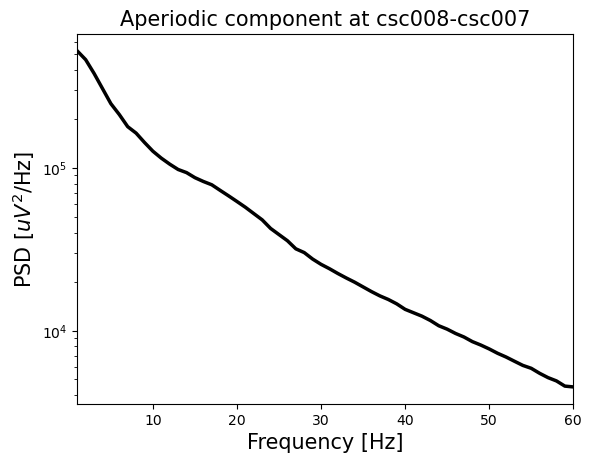

In [97]:
dat = df_aperiodic_mean.iloc[0,:60].tolist()
plt.plot(freqs, dat, 'k', lw = 2.5)
plt.xlim(1, 60)
plt.yscale('log') # log-log scale
plt.title(f'Aperiodic component at {chan[0]}', fontsize = 15)
plt.xlabel('Frequency [Hz]', fontsize = 15)
plt.ylabel('PSD [$uV^2$/Hz]', fontsize = 15)